# EDA on augmented data

In [26]:
# Open swiss data GeoDataFrame
import geopandas as gpd
import pandas as pd
from shapely import wkt

# Load the data
gdf = gpd.read_file('processed_data/swiss_data_all_with_temp.csv')
gdf.drop(columns=["field_1"], inplace=True)

gdf.head()

,idx,geometry,altitude,TypoCH_NUM,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI,mean_annual_temp
0,264,"POLYGON ((2486071.58 1112261.72, 2487071.58 11...",374.268,82.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,10.4
1,265,"POLYGON ((2486071.58 1113261.72, 2487071.58 11...",411.3956,12.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,10.100000000000001
2,269,"POLYGON ((2486071.58 1117261.72, 2487071.58 11...",461.3668,62.0,"eutric, gleyic, dystric, calcaric Cambisol; or...",5.0,4.0,6.0,9.700000000000001
3,270,"POLYGON ((2486071.58 1118261.72, 2487071.58 11...",470.4324,82.0,"eutric, gleyic, dystric, calcaric Cambisol; or...",5.0,4.0,6.0,9.8
4,490,"POLYGON ((2487071.58 1112261.72, 2488071.58 11...",381.006,82.0,"eutric Fluvisol; gleyic, eutric, calcaric Camb...",5.0,4.0,5.0,10.4


In [27]:
#Ajout des présences
from shapely import *
from shapely.wkt import *

df_presence_csv_path = 'processed_data/df_berce_clean.csv'
df_presence = pd.read_csv(df_presence_csv_path)

gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.set_crs(epsg=2056, inplace=True)


# Supposons que les coordonnées géographiques sont stockées dans les colonnes 'latitude' et 'longitude'
geometry = [Point(xy) for xy in zip(df_presence['decimalLongitude'], df_presence['decimalLatitude'])]
gdf_presence = gpd.GeoDataFrame(df_presence, geometry=geometry, crs="EPSG:4326")

# Étape 2 : Conversion des coordonnées géographiques en LV95
gdf_presence = gdf_presence.to_crs(epsg=2056)

# Étape 3 : Création de la colonne "Presence" dans gdf et initialisation à 0
gdf['Presence'] = 0
gdf['Count'] = 0

# Étape 4 : Comptage des points présents dans chaque zone et incrémentation de la colonne "Presence"
for i, zone in gdf.iterrows(): # TODO : Make it as a func and aply it to gdf !
    # Compter les points de gdf_presence qui sont dans la zone actuelle
    points_in_zone = gdf_presence[gdf_presence.geometry.within(zone.geometry)]
    # Incrémenter la colonne 'Presence' par le nombre de points trouvés
    if len(points_in_zone) > 0 :
        gdf.at[i, 'Presence'] = 1
        gdf.at[i, 'Count'] += len(points_in_zone)

In [28]:
gdf = gdf.drop(columns=['geometry', 'Count'])

In [29]:
gdf['altitude'] = gdf['altitude'].astype(float)
gdf['mean_annual_temp'] = gdf['mean_annual_temp'].astype(float)

In [30]:
#Récupération des données avec une présence à 1
gdfHist = gdf[gdf['Presence'] == 1]

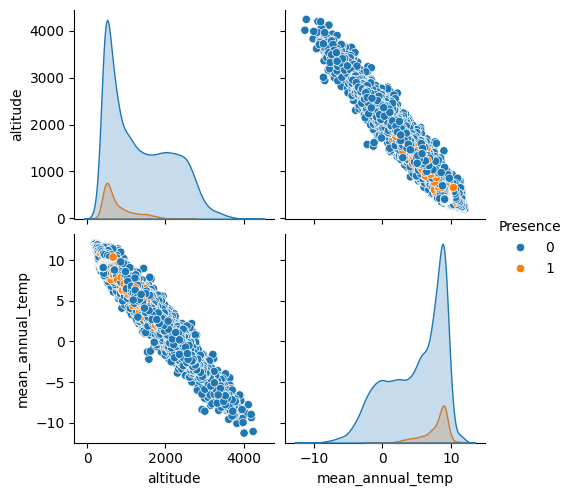

In [31]:
import seaborn as sns

sns.pairplot(gdf, hue='Presence')

In [ ]:
# TODO traduire les labels des features

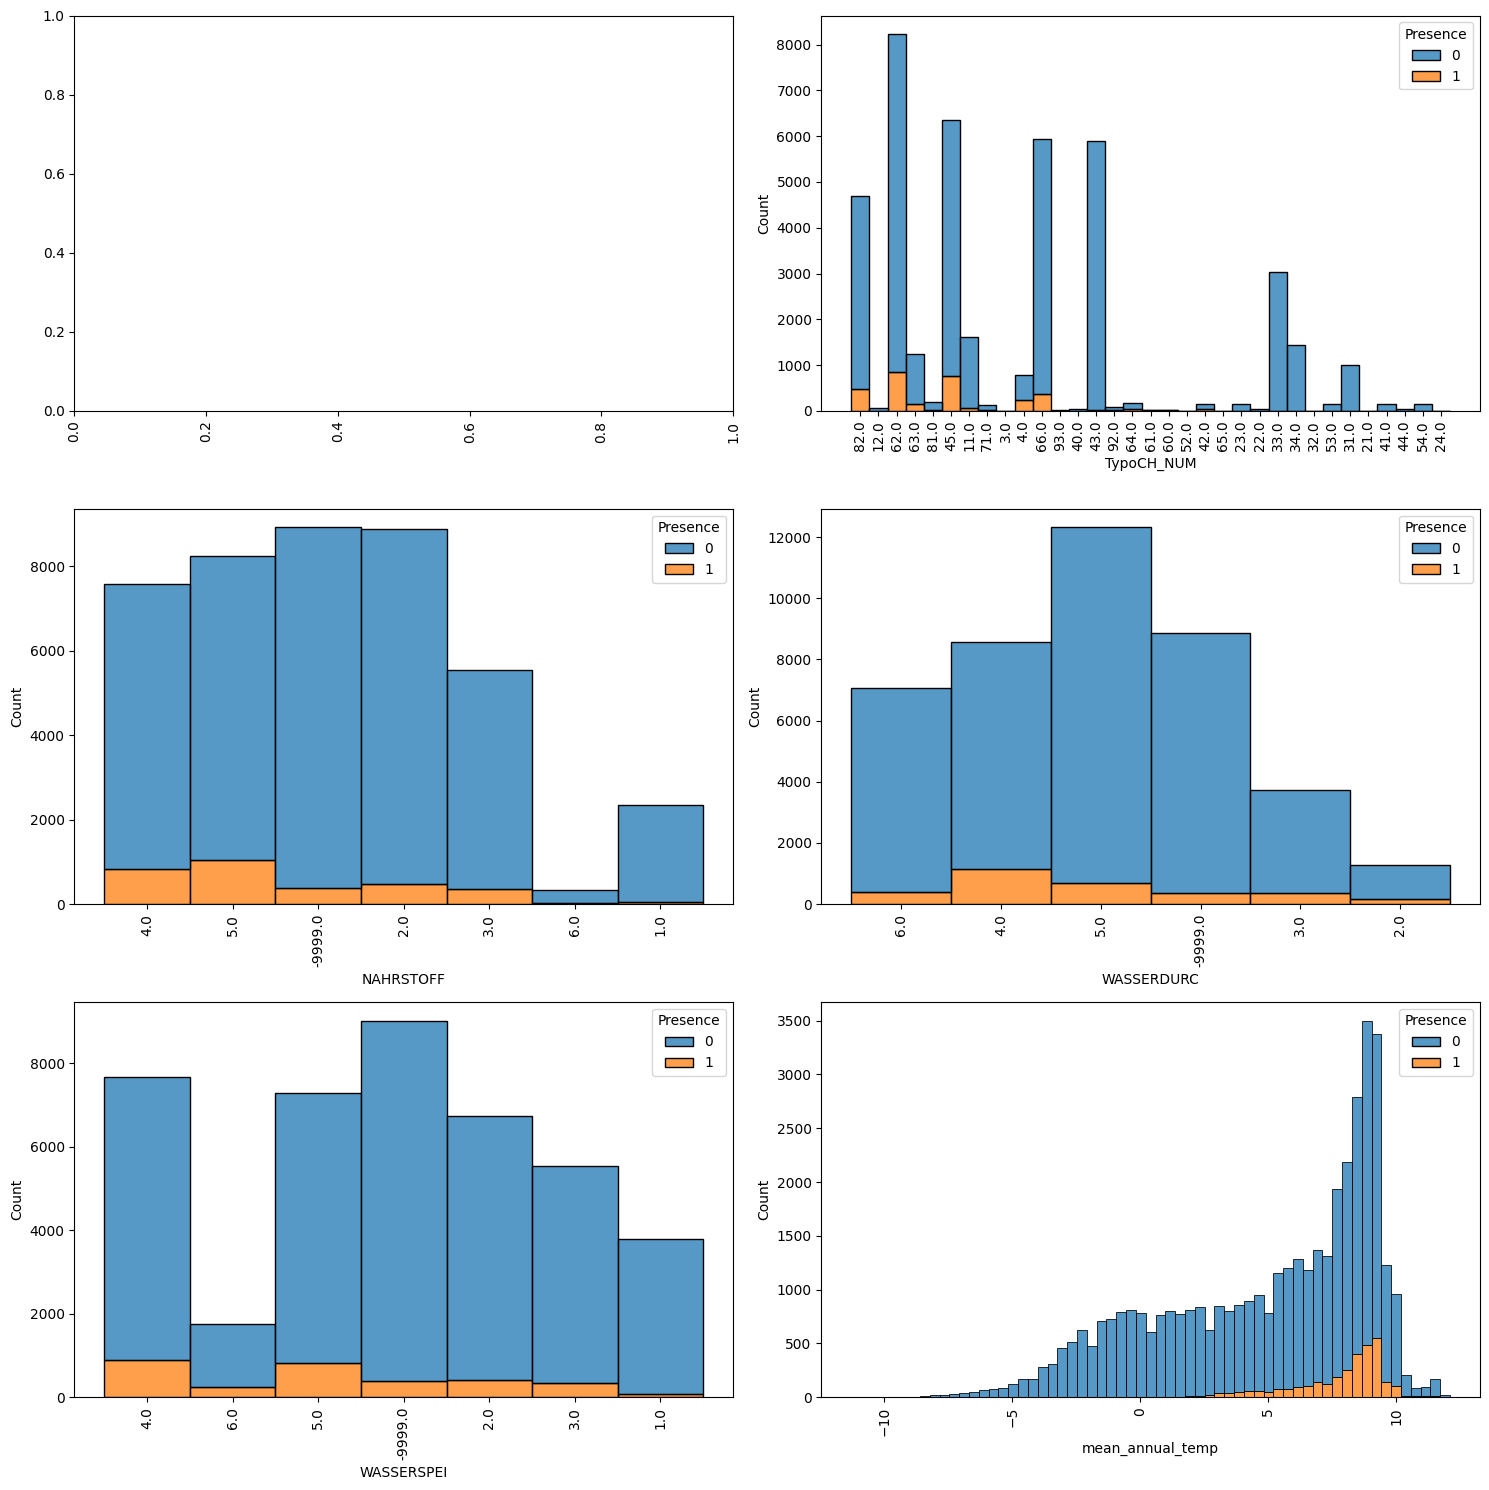

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

#sns.histplot(data=gdf, x='Bodentyp', hue='Presence', multiple='stack', ax=axs[0, 0])
sns.histplot(data=gdf, x='TypoCH_NUM', hue='Presence', multiple='stack', ax=axs[0, 1])
sns.histplot(data=gdf, x='NAHRSTOFF', hue='Presence', multiple='stack', ax=axs[1, 0])
sns.histplot(data=gdf, x='WASSERDURC', hue='Presence', multiple='stack', ax=axs[1, 1])
sns.histplot(data=gdf, x='WASSERSPEI', hue='Presence', multiple='stack', ax=axs[2, 0])
sns.histplot(data=gdf, x='mean_annual_temp', hue='Presence', multiple='stack', ax=axs[2, 1])

for ax in axs.flat:
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()
